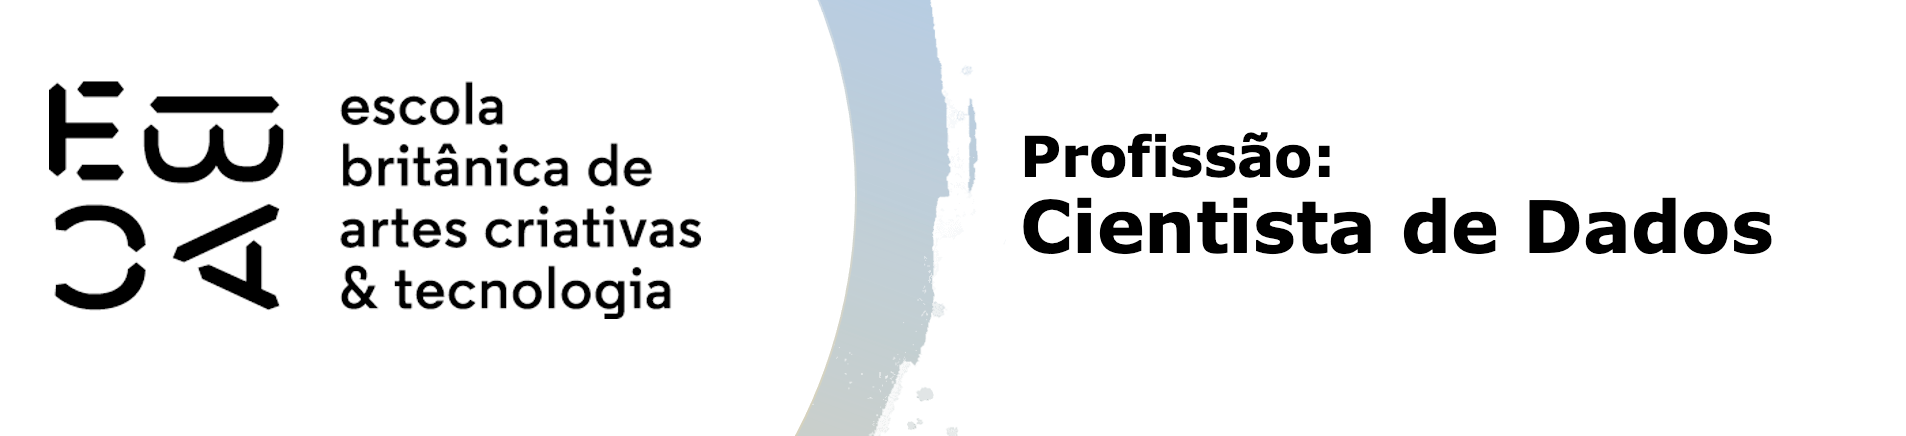

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [3]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [4]:
# Antes de começarmos iremos transformar a variável resposta em númerica.

df['mau'] = df['mau'].astype('int64')

In [5]:
# Separando os últimos 3 meses como safras de oot

df_oot = df[df['data_ref'] > (df['data_ref'].max() - pd.DateOffset(months= 3))]
df_oot.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
600000,2016-01-01,8906,F,S,S,2,Assalariado,Superior completo,Casado,Casa,38,7.383562,4.0,2969.49,1
600001,2016-01-01,5063,F,N,S,0,Assalariado,Médio,Casado,Casa,55,8.471233,2.0,6278.37,0
600002,2016-01-01,16401,M,S,S,1,Assalariado,Médio,União,Casa,39,8.884932,3.0,14010.18,0
600003,2016-01-01,6786,F,N,S,1,Assalariado,Médio,União,Com os pais,31,1.794521,3.0,2875.81,0
600004,2016-01-01,13466,M,S,N,0,Assalariado,Médio,Casado,Casa,27,7.019178,2.0,2737.19,0


In [6]:
df_test = df[~(df['data_ref'] > (df['data_ref'].max() - pd.DateOffset(months= 3)))]
df_test.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0


In [7]:
# Além disso, iremos preencher os valores NaN pela média dos valores desta coluna.

df_test['tempo_emprego'] = df_test['tempo_emprego'].fillna(df_test['tempo_emprego'].mean())
df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(df_oot['tempo_emprego'].mean())

C:\Users\samsun\AppData\Local\Temp\ipykernel_21124\1218712067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['tempo_emprego'] = df_test['tempo_emprego'].fillna(df_test['tempo_emprego'].mean())
C:\Users\samsun\AppData\Local\Temp\ipykernel_21124\1218712067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oot['tempo_emprego'] = df_oot['tempo_emprego'].fillna(df_oot['tempo_emprego'].mean())


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [8]:
# Começamos descrevendo a base em relação a coluna 'data_ref'

desc_mes = df_test.groupby(df_test['data_ref'].dt.to_period('M'))['data_ref'].size()
desc_mes

data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
Freq: M, Name: data_ref, dtype: int64

- Como podemos ver, cada mês possui 50000 linhas, totalizando 600000 linhas deste dataframe.

In [9]:
# Para fazer uma análise descritiva, iremos primeiramente criar funções pertinentes para isso, serão a de calcular e classificar o IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

def cat_iv(iv):
    if iv < 0.02:
        return 'inútil'
    elif iv < 0.1:
        return 'fraca'
    elif iv < 0.3:
        return 'média'
    elif iv < 0.5:
        return 'forte'
    else:
        return 'suspeitamente forte'

In [10]:
# Aqui será feita uma descrição simples das variáveis quantitativas

df_test[['idade', 'renda', 'tempo_emprego', 'tempo_emprego']].describe()

,idade,renda,tempo_emprego,tempo_emprego
count,600000.000000,6.000000e+05,600000.000000,600000.000000
mean,43.798530,2.722284e+04,7.747992,7.747992
std,11.230659,8.737788e+04,6.100461,6.100461
min,22.000000,1.618600e+02,0.117808,0.117808
25%,34.000000,4.670600e+03,3.635616,3.635616
50%,43.000000,9.887580e+03,7.473973,7.473973
75%,53.000000,2.162887e+04,9.069863,9.069863
max,68.000000,4.083986e+06,42.906849,42.906849


Text(0.5, 1.0, 'Histograma da renda')

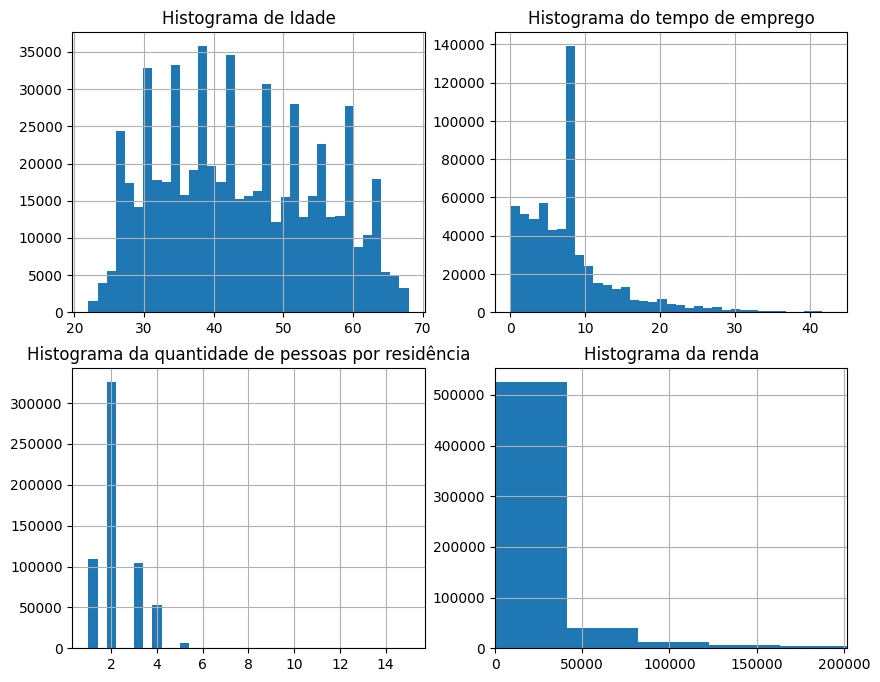

In [11]:
# Iremos aqui plotar histogramas com todas as variáveis numéricas.
# 'qtd_filhos' será deixada de fora pois seu IV é extremamente baixo, até mesmo em comparação as outras variávies.
fig, axs = plt.subplots(2,2, figsize=(10, 8))

df_test['idade'].hist(bins=35, ax=axs[0, 0])
axs[0, 0].set_title('Histograma de Idade')

df_test['tempo_emprego'].hist(bins = 35, ax = axs[0,1])
axs[0, 1].set_title('Histograma do tempo de emprego')

df_test['qt_pessoas_residencia'].hist(bins = 35, ax = axs[1,0])
axs[1, 0].set_title('Histograma da quantidade de pessoas por residência')

# Como os valores de renda variam muito, o eixo x mostrará de zero até a média mais o dobro do desvio padrão.
df_test['renda'].hist(bins = 100, ax = axs[1,1])
axs[1, 1].set_xlim(0, df_test['renda'].mean() + (2*df_test['renda'].std()))
axs[1, 1].set_title('Histograma da renda')


In [12]:
# Agora iremos descrever as variáveis qualitativas também

df_test[['sexo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'tipo_residencia', 'estado_civil']].describe()

,sexo,posse_de_imovel,tipo_renda,educacao,tipo_residencia,estado_civil
count,600000,600000,600000,600000,600000,600000
unique,2,2,5,5,6,5
top,F,S,Assalariado,Médio,Casa,Casado
freq,403805,403054,308460,405449,539336,421149


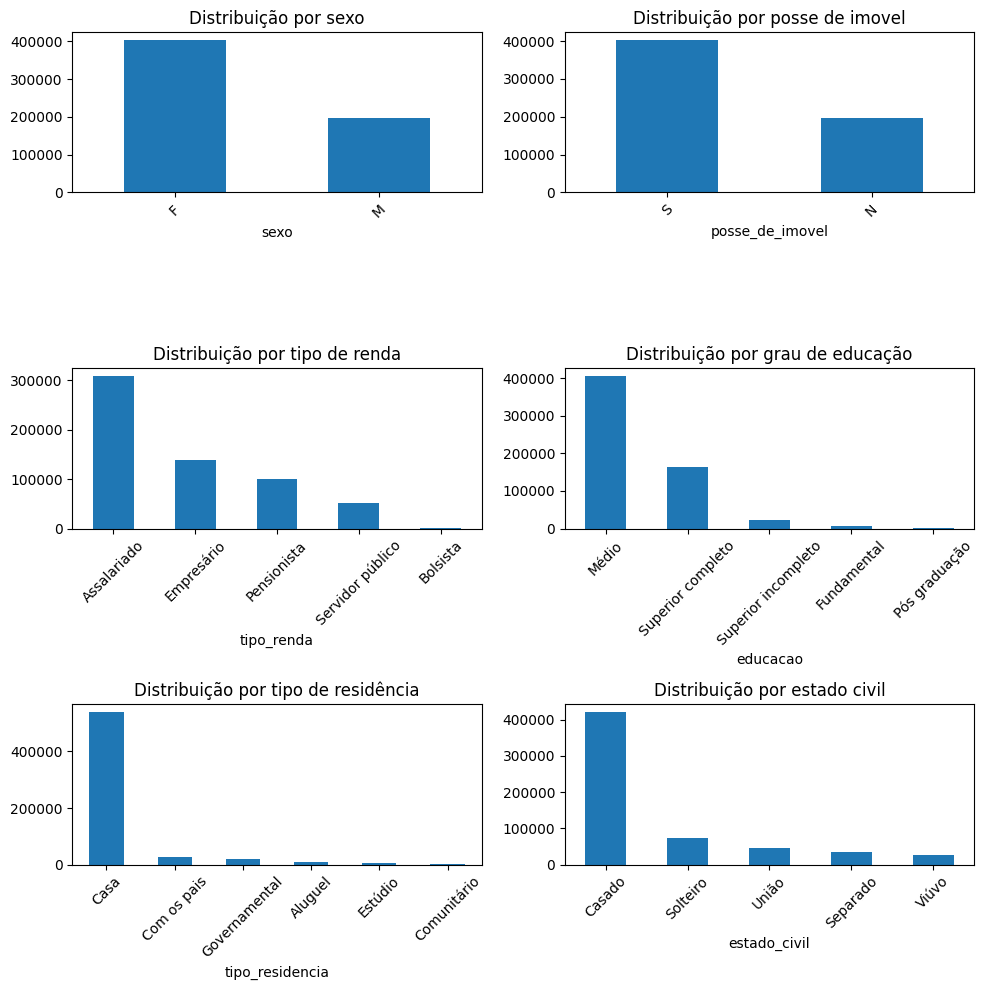

In [13]:
# Agora iremos fazer o mesmo para as variáveis categóricas.
# Novamente, 'posse_de_veiculo' será deixada de fora, pois seu IV é muito pequeno.
fig, axs = plt.subplots(3,2, figsize=(10, 10))

df_test['sexo'].value_counts().plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_title('Distribuição por sexo')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=45)

df_test['posse_de_imovel'].value_counts().plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_title('Distribuição por posse de imovel')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45)

df_test['tipo_renda'].value_counts().plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_title('Distribuição por tipo de renda')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45)

df_test['educacao'].value_counts().plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_title('Distribuição por grau de educação')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)

df_test['tipo_residencia'].value_counts().plot(kind='bar', ax=axs[2, 0])
axs[2, 0].set_title('Distribuição por tipo de residência')
axs[2, 0].set_xticklabels(axs[2, 0].get_xticklabels(), rotation=45)

df_test['estado_civil'].value_counts().plot(kind='bar', ax=axs[2, 1])
axs[2, 1].set_title('Distribuição por estado civil')
axs[2, 1].set_xticklabels(axs[2, 1].get_xticklabels(), rotation=45)

plt.subplots_adjust(hspace=0.8)
plt.tight_layout()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [14]:
# Iremos agora fazer uma tabela contendo os valores de IV para cada variável com relação a 'mau'

metadados = pd.DataFrame(df_test.dtypes, columns=['dtype'])
metadados['nmissing'] = df_test.isna().sum()
metadados['valores_unicos'] = df_test.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'


for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_test[var],5,duplicates='drop'), df_test.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_test[var], df_test.mau)
        
metadados['faixa_iv'] = metadados['IV'].apply(lambda iv: cat_iv(iv))
metadados


,dtype,nmissing,valores_unicos,papel,IV,faixa_iv
data_ref,datetime64[ns],0,12,covariavel,0.247065,média
index,int64,0,16650,covariavel,0.002716,inútil
sexo,object,0,2,covariavel,0.002665,inútil
posse_de_veiculo,object,0,2,covariavel,0.000075,inútil
posse_de_imovel,object,0,2,covariavel,0.009690,inútil
qtd_filhos,int64,0,8,covariavel,0.000055,inútil
tipo_renda,object,0,5,covariavel,0.009718,inútil
educacao,object,0,5,covariavel,0.003690,inútil
estado_civil,object,0,5,covariavel,0.001305,inútil
tipo_residencia,object,0,6,covariavel,0.003330,inútil


- Como visto na tabela acima, a maioria das variáveis possui IV muito pequeno para ser útil, a única exceção é 'tempo_emprego', sendo que 'renda' é forte demais, logo, ulitizá-la acarreta o risco de overfitting.
- Além disso, 'tempo_emprego' foi alterada anteriormente, com isso, é esperado que seu IV também seja influenciado.
- Por isso, iremos usar uma gama de valores de IV maior, admitiremos todos aqueles com IV acima de 0,005.

C:\Users\samsun\AppData\Local\Temp\ipykernel_21124\3269953540.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45)
C:\Users\samsun\AppData\Local\Temp\ipykernel_21124\3269953540.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)


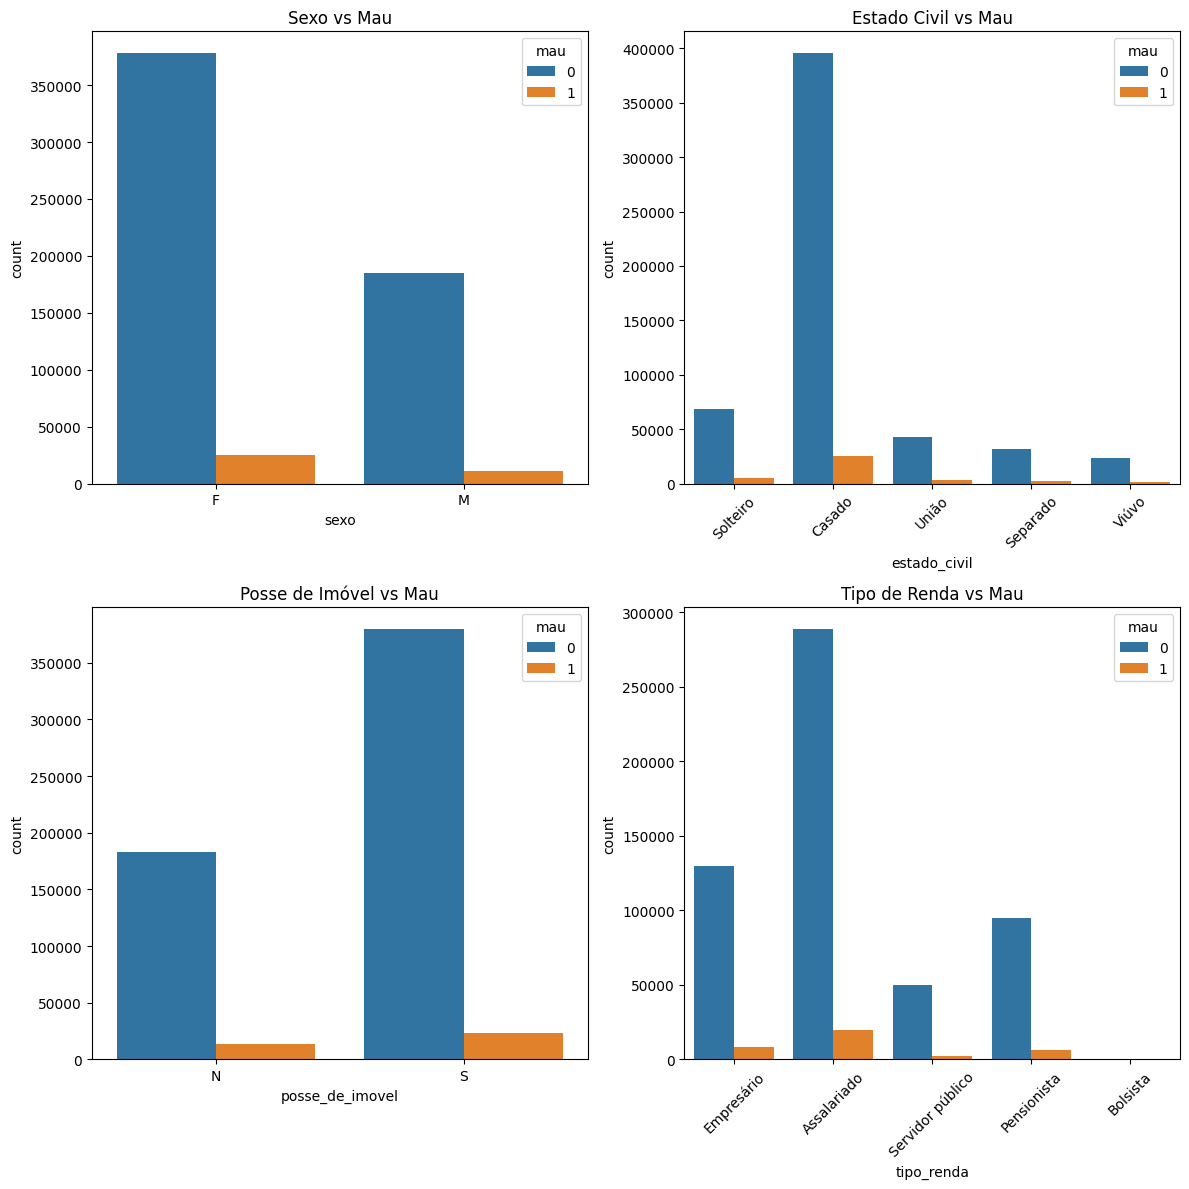

In [15]:
# Agora iremos criar bivariadas para as variáveis categóricas.
# Como 'mau' é a variável resposta do nosso modelo, iremos fazer todos os graficos em função desta.

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

sns.countplot(x='sexo', hue='mau', data=df_test, ax=axs[0, 0])
axs[0, 0].set_title('Sexo vs Mau')

sns.countplot(x='estado_civil', hue='mau', data=df_test, ax=axs[0, 1])
axs[0, 1].set_title('Estado Civil vs Mau')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45)

sns.countplot(x='posse_de_imovel', hue='mau', data=df_test, ax=axs[1, 0])
axs[1, 0].set_title('Posse de Imóvel vs Mau')

sns.countplot(x='tipo_renda', hue='mau', data=df_test, ax=axs[1, 1])
axs[1, 1].set_title('Tipo de Renda vs Mau')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=45)


plt.subplots_adjust(hspace=0.8)
plt.tight_layout()


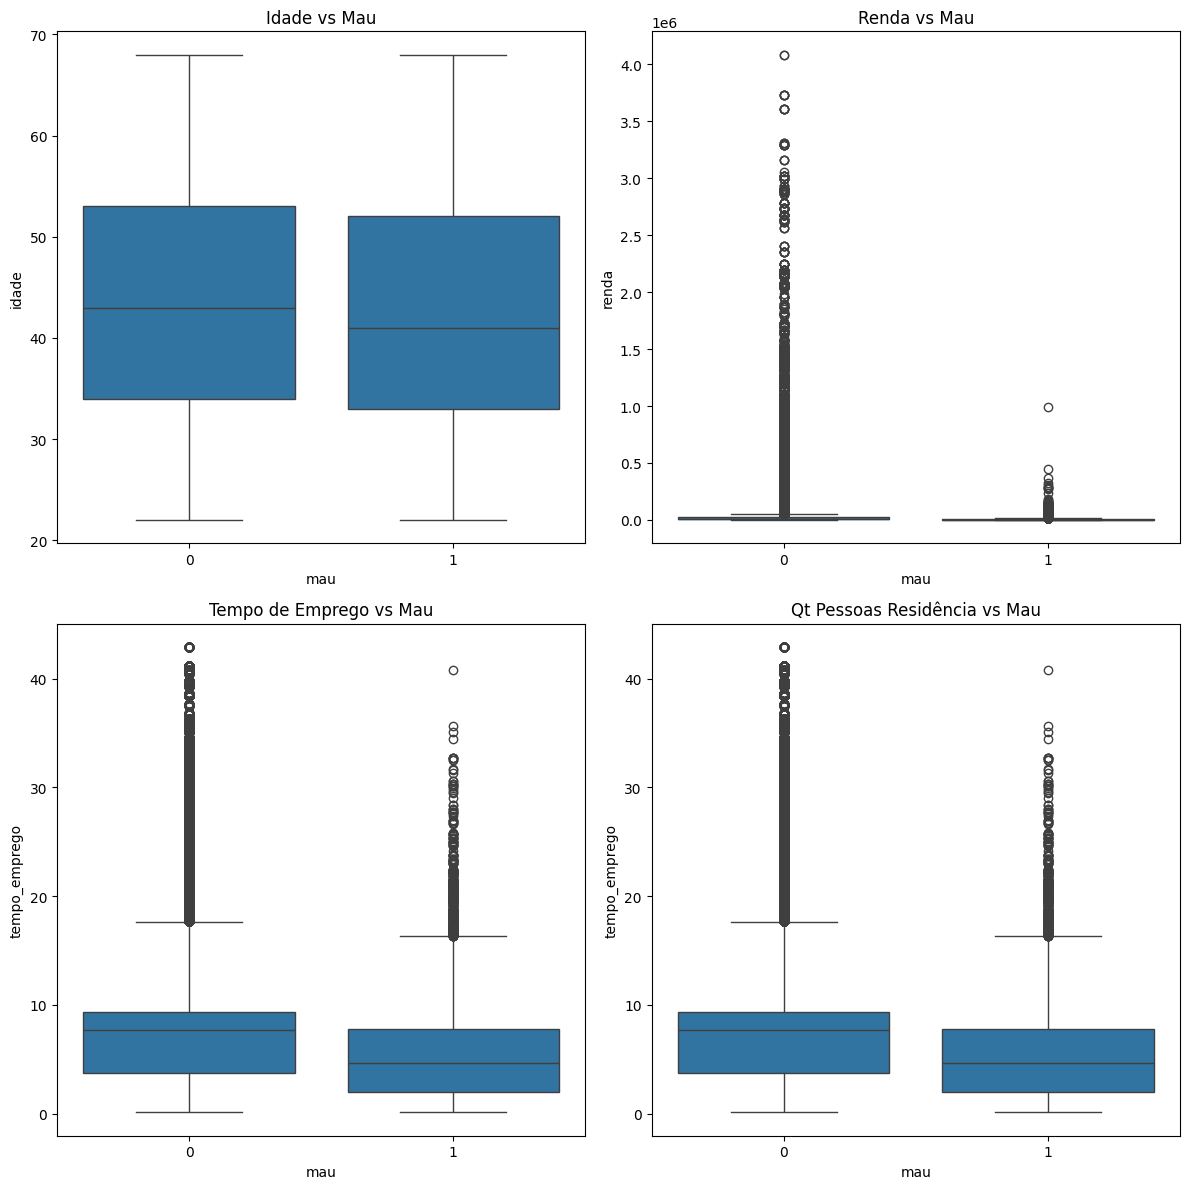

In [16]:
# Por fim, faremos boxplots de variáveis númericas com relação a 'mau'

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

sns.boxplot(x='mau', y='idade', data=df_test, ax=axs[0, 0])
axs[0, 0].set_title('Idade vs Mau')

sns.boxplot(x='mau', y='renda', data=df_test, ax=axs[0, 1])
axs[0, 1].set_title('Renda vs Mau')

sns.boxplot(x='mau', y='tempo_emprego', data=df_test, ax=axs[1, 0])
axs[1, 0].set_title('Tempo de Emprego vs Mau')

sns.boxplot(x='mau', y='tempo_emprego', data=df_test, ax=axs[1, 1])
axs[1, 1].set_title('Qt Pessoas Residência vs Mau')

plt.tight_layout()
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [23]:
formula = '''mau ~  posse_de_imovel + tipo_renda  + idade + tempo_emprego'''

rl = smf.glm(formula, data=df_test, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599992
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3287e+05
Date:                Fri, 13 Sep 2024   Deviance:                   2.6575e+05
Time:                        00:09:19   Pearson chi2:                 6.00e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01676
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.7355      0.026    -65.946      0.000      -1.787      -1.684
posse_de_imovel[T.S]              -0.2098      0.011    -18.418      0.000      -0.232      -0.187
tipo_renda[T.Bolsista]             0.2322      0.295      0.787      0.432      -0.346       0.811
tipo_renda[T.Empresário]          -0.1465      0.014    -10.705      0.000      -0.173      -0.120
tipo_renda[T.Pensionista]          0.3002      0.020     15.363      0.000       0.262       0.338
tipo_renda[T.Servidor público]    -0.1137      0.023     -4.992      0.000      -0.158      -0.069
idade                             -0.0021      0.001     -3.287      0.001      -0.003      -0.001
tempo_emprego                     -0.1240      0.002    -80.634      0.000      -0.127      -0.121
==================================================================================================
"""

In [24]:
rl.params

Intercept                        -1.735533
posse_de_imovel[T.S]             -0.209791
tipo_renda[T.Bolsista]            0.232158
tipo_renda[T.Empresário]         -0.146532
tipo_renda[T.Pensionista]         0.300156
tipo_renda[T.Servidor público]   -0.113745
idade                            -0.002087
tempo_emprego                    -0.124039
dtype: float64

Temos que a fórmula geral para esse modelo de logit é:

$$ log(\frac {P(mau =1)}{1 - P(mau =1)}) =  \Beta_0 +  \Beta_1.x_1 + \Beta_2.x_2 + \Beta_3.x_3 + \Beta_4.x_4 $$



onde:

$\Beta_0 = $ intercepto 

$ x_1 = $ posse_de_imovel

$ x_2 = $ tipo_renda

$ x_3 = $ idade

$ x_4 = $ tempo_emprego

Reorganizando e equação temos:


$$P(mau=1) = \frac{1}{1+\exp{-(\Beta_0 +  \Beta_1.x_1 + \Beta_2.x_2 + \Beta_3.x_3 + \Beta_4.x_4)}}           $$

Sendo que os coeficientes x serão substituídos pelos parametros do modelo acima, com destaque para o caso da variável 'tipo_renda', onde seu coeficiente mudará de acordo com a categoria em questão.

Essa equação é a equação descritiva do modelo em questão, ela irá calcular a probabilidade de 'mau' ser 1 para cada linha do dataframe com base no modelo construído.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [25]:
df_oot['score'] = rl.predict(df_oot)

# Acurácia
acc = metrics.accuracy_score(df_oot.mau, df_oot.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_oot.mau, df_oot.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_oot.loc[df_oot.mau == 1, 'score'], df_oot.loc[df_oot.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 63.3% 
AUC: 64.7% 
GINI: 29.4%
KS: 20.4%


C:\Users\samsun\AppData\Local\Temp\ipykernel_21124\581326728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oot['score'] = rl.predict(df_oot)
